In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import kpss
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from river import compose, stream
from river import drift
from matplotlib import gridspec
from river import forest
from river import metrics

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import  roc_curve,auc

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('data/elec2_original.csv')

In [ ]:
df['date']=pd.to_datetime(df['date'], format='mixed').dt.month
df.rename(columns={'date':'month'}, inplace=True)

In [ ]:
# Dataset Basic Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   month      45312 non-null  int32 
 1   day        45312 non-null  int64 
 2   period     45312 non-null  int64 
 3   nswprice   45312 non-null  int64 
 4   nswdemand  45312 non-null  int64 
 5   vicprice   45312 non-null  int64 
 6   vicdemand  45312 non-null  int64 
 7   transfer   45312 non-null  int64 
 8   class      45312 non-null  object
dtypes: int32(1), int64(7), object(1)
memory usage: 2.9+ MB


In [ ]:
# Target variable distinct classes
df['class'].unique()

array(['UP', 'DOWN'], dtype=object)

# Checking stationarity using KPSS test

In [ ]:
vicprice_series = df['nswprice']

# Perform KPSS test
kpss_stat, p_value, lags, crit_values = kpss(vicprice_series)

# Print the results
print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)
print('Critical Values:')
for key, value in crit_values.items():
    print(f'   {key}: {value}')

# Interpret the results
if p_value < 0.05:
    print("Null hypothesis is rejected. The series is not stationary.")
else:
    print("Fail to reject null hypothesis. The series may be stationary.")

KPSS Statistic: 5.61191652132697
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Null hypothesis is rejected. The series is not stationary.


# Correlation analysis

# Linear Correlation

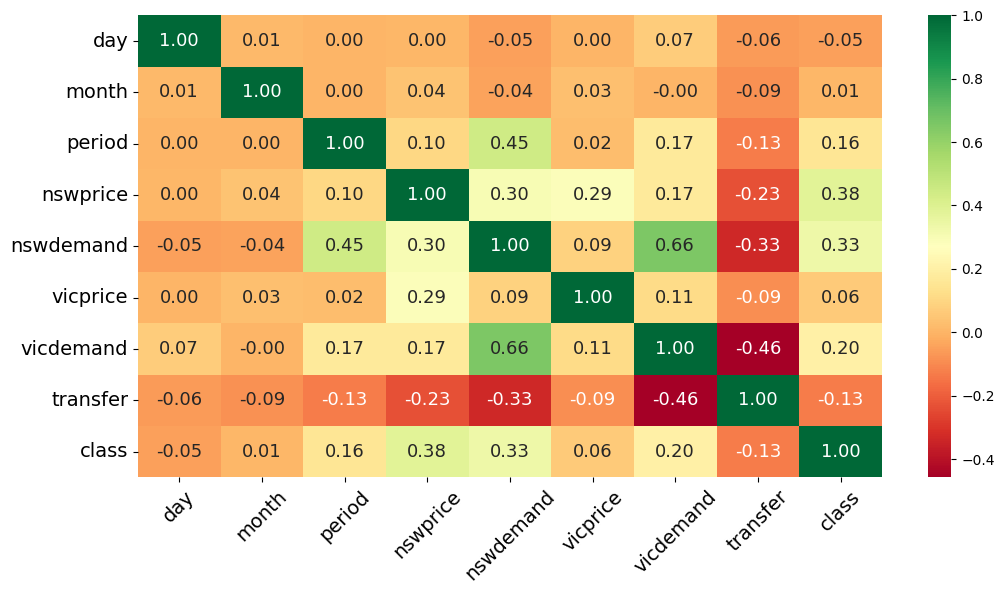

In [ ]:
# Label Encoding
data=df.copy()
label_encoder = preprocessing.LabelEncoder() 
data['class']= label_encoder.fit_transform(data['class']) 

corr=data [['day', 'month','period', 'nswprice', 'nswdemand', 'vicprice','vicdemand', 'transfer', 'class']].corr()
fig, ax = plt.subplots(figsize=(12,6))
heatmap=sns.heatmap(data=corr, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax, annot_kws={"size": 13})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
#plt.subtitle('Correlation Matrix',fontsize=20)
plt.show()

# Non-Linear Correlation

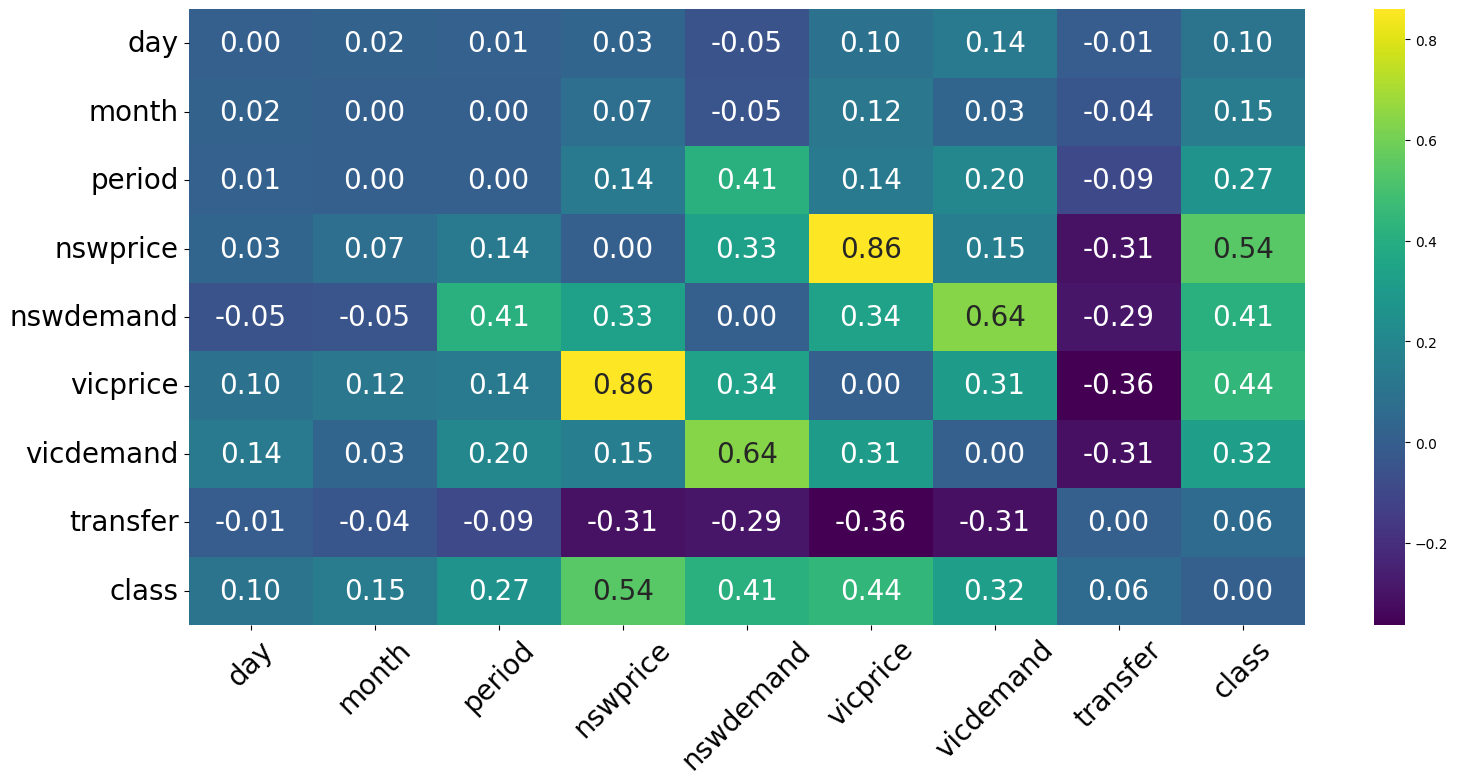

In [ ]:
data=df[['day', 'month','period', 'nswprice', 'nswdemand', 'vicprice','vicdemand', 'transfer', 'class']]
def rank_correlation_ratio(a, b):
    """
    Computes the Rank Correlation Ratio (RCR) between two columns.
    """
    a_rank = a.rank()
    b_rank = b.rank()
    
    numerator = np.sum((a_rank - b_rank) ** 2)
    denominator = np.sum((a_rank ** 2) + (b_rank ** 2))
    
    return 1 - (6 * numerator / (len(a) * (len(a) ** 2 - 1)))

def compute_rcr_matrix(data):
    """
    Computes the RCR matrix for a given dataframe.
    """
    columns = data.columns
    n = len(columns)
    rcr_matrix = np.zeros((n, n))
    
    for i, j in combinations(range(n), 2):
        rcr = rank_correlation_ratio(data.iloc[:, i], data.iloc[:, j])
        rcr_matrix[i, j] = rcr
        rcr_matrix[j, i] = rcr
    
    return rcr_matrix

def display_heatmap(rcr_matrix, columns):
    """
    Displays the heatmap for the RCR matrix.
    """
# sns.heatmap(rcr_matrix, annot=True, fmt=".2f", xticklabels=columns, yticklabels=columns, cmap="coolwarm")
    
    plt.figure(figsize=(18, 8))
    heatmap=sns.heatmap(rcr_matrix, annot=True, cmap='viridis', fmt='.2f', xticklabels=columns, yticklabels=columns,  annot_kws={"size": 20})
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, fontsize=20)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
    # plt.title('Non-linear Correlation Matrix with Rank Correlation Ratio (RCR) ')


# Compute RCR matrix
rcr_matrix = compute_rcr_matrix(data)

# Display heatmap
display_heatmap(rcr_matrix, data.columns)

# Creating Data Stream

In [ ]:
dic = {'UP': True, 'DOWN': False}
df['class']=df['class'].map(dic)
X=df
y=X.pop('class')

In [ ]:
data_stream=stream.iter_pandas(X,y)
x, y = next(iter(data_stream))
print(x,"=========>", y)

{'month': 7, 'day': 2, 'period': 1, 'nswprice': 1880, 'nswdemand': 7226, 'vicprice': 1669, 'vicdemand': 4521, 'transfer': 195} =========> True


# Drift analysis

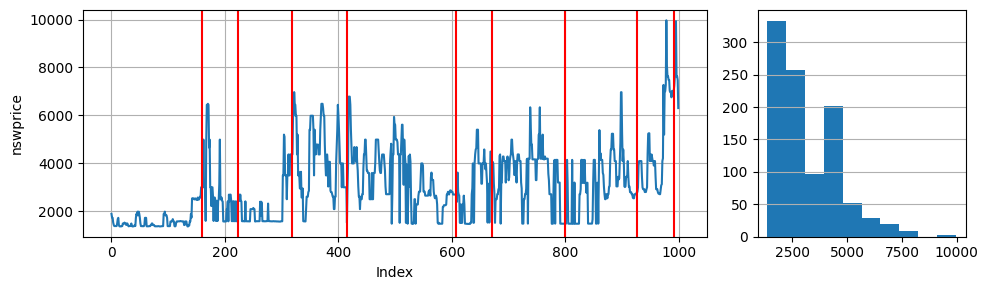

In [ ]:
def plot_data(nswprice, drifts=None):
    fig = plt.figure(figsize=(10,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('nswprice')
    ax2.grid(axis='y')
    ax2.hist(stream, label=r'$nswprice$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

# Drfit Detection

stream=df['nswprice'][:1000]
drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        # print(f'Change detected at index {i}')
        drifts.append(i)

plot_data(stream,drifts)

# Creating a machine learning pipeline

In [ ]:
model = compose.Pipeline( preprocessing.StandardScaler(),
                         feature_extraction.PolynomialExtender(degree=2),
                         forest.ARFClassifier(grace_period=50, delta=0.01))

# Creating an offline learning model

In [ ]:
# Import the dataset
df=pd.read_csv('data/elec2_original.csv')
df=df.drop('date', axis=1)
d = {'UP': True, 'DOWN': False}
df['class']=df['class'].map(d)
X=df
y=X.pop('class')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# model = RandomForestClassifier(n_estimators=100, random_state=0)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rocauc = roc_auc_score(y_test, y_pred)
print("ROCAUC:", rocauc)

# Print classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

Accuracy: 0.7951009599470374
ROCAUC: 0.7799540755933266


# Model pre-training

In [ ]:
df=pd.read_csv('data/elec2_original.csv')
# df=df.head(5000)
df['date']=pd.to_datetime(df['date'], format='mixed').dt.month
df.rename(columns={'date':'month'}, inplace=True)

In [ ]:
dic = {'UP': True, 'DOWN': False}
df['class']=df['class'].map(dic)
X=df
y=X.pop('class')

In [ ]:
data_stream=stream.iter_pandas(X,y)
model = forest.ARFClassifier()
metric = metrics.ROCAUC()

In [ ]:
for i, (x, y) in zip(range(len(X)),data_stream):
    y_pred = model.predict_proba_one(x)
    model.learn_one(x, y)
    if (i>=len(X)*0.8):
        metric.update(y, y_pred)

In [ ]:
metric

ROCAUC: 94.21%

In [ ]:
y

False

# Step by step Online Learning

In [ ]:
df=pd.read_csv('data/elec2_original.csv')
df['date']=pd.to_datetime(df['date'], format='mixed').dt.month
df.rename(columns={'date':'month'}, inplace=True)
dic = {'UP': True, 'DOWN': False}
df['class']=df['class'].map(dic)
X=df
y=X.pop('class')

In [ ]:
model = forest.ARFClassifier(delta=0.01)

In [ ]:
metric = metrics.ROCAUC()

In [ ]:
data_stream=stream.iter_pandas(X,y)
for x, y in data_stream:
    y_pred = model.predict_proba_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)

In [ ]:
metric

ROCAUC: 93.73%

# Online learning pipeline and model evaluation

In [ ]:
from river import ensemble
from river import preprocessing

In [ ]:
df=pd.read_csv('data/elec2_original.csv')
df['date']=pd.to_datetime(df['date'], format='mixed').dt.month
df.rename(columns={'date':'month'}, inplace=True)
# df=df.head(1000)

In [ ]:
dic = {'UP': True, 'DOWN': False}
df['class']=df['class'].map(dic)
X=df
y=X.pop('class')

In [ ]:
data_stream=stream.iter_pandas(X,y)

In [ ]:
def evaluate_model(model): 
    
    metric = metrics.ROCAUC()

    y_trues = []
    y_preds = []
    i=0
    for x, y in data_stream:
        i=i+1
        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        if i!=1:
            metric.update(y, y_pred)
            y_trues.append(y)
            y_preds.append(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_trues, y_preds)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# #############################33
    cm = confusion_matrix(y_trues, np.array(y_preds))
    # Plot confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
#################################
    print(classification_report(y_trues, np.array(y_preds)))

In [ ]:
base_model = compose.Pipeline(preprocessing.StandardScaler() |
                              feature_extraction.PolynomialExtender(degree=3) |
                              forest.ARFClassifier(grace_period=50, delta=0.01)) 
model = ensemble.SRPClassifier(model=base_model, n_models=3, seed=42)

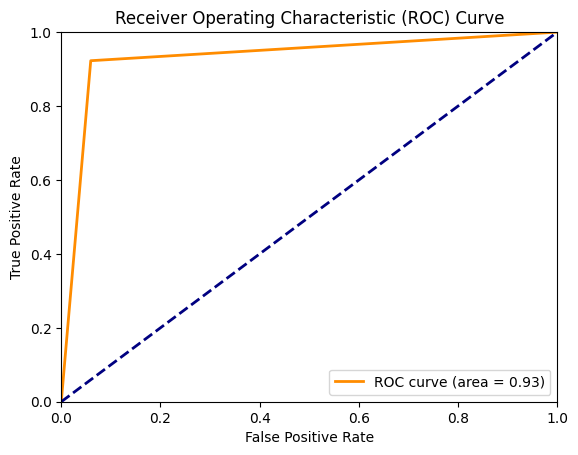

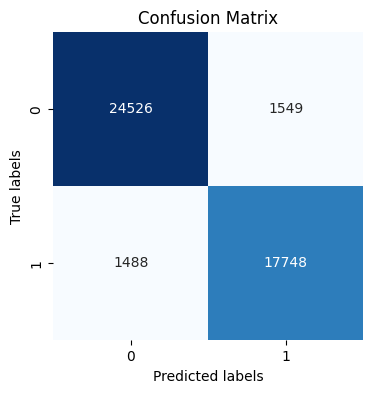

              precision    recall  f1-score   support

       False       0.94      0.94      0.94     26075
        True       0.92      0.92      0.92     19236

    accuracy                           0.93     45311
   macro avg       0.93      0.93      0.93     45311
weighted avg       0.93      0.93      0.93     45311



In [ ]:
evaluate_model(model)